In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 63.1 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=9377046f77b97b4a8d24babc7982657180d1ec038d2c614b2c02f83a304ca152
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=3d24a796f95d4c88c23062df4a4ecdbc6b449525dc8f11c7d60db82734bfecf2
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels
  Cloning https://github.com/albumentations-team/albumenta

In [2]:
!git clone https://github.com/parth1620/Person-Re-Id-Dataset

Cloning into 'Person-Re-Id-Dataset'...
remote: Enumerating objects: 12942, done.
remote: Counting objects: 100% (12942/12942), done.
remote: Compressing objects: 100% (12942/12942), done.
remote: Total 12942 (delta 0), reused 12942 (delta 0), pack-reused 0
Receiving objects: 100% (12942/12942), 27.68 MiB | 15.93 MiB/s, done.
Updating files: 100% (12939/12939), done.


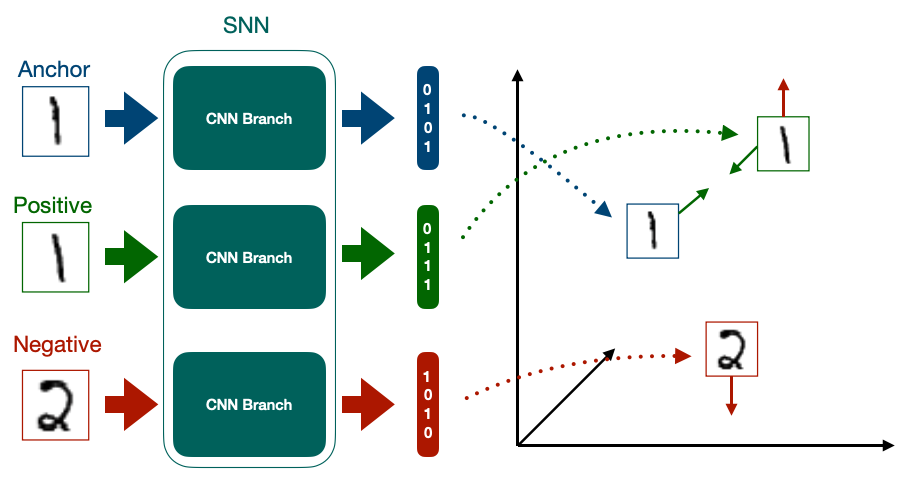

# Imports

In [40]:
import sys
sys.path.append('/content/Person-Re-Id-Dataset')

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import timm

import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader

from skimage import io
from sklearn.model_selection import train_test_split

from tqdm import tqdm

# Configurations

In [43]:
DATA_DIR = '/content/Person-Re-Id-Dataset/train/'
CSV_FILE = '/content/Person-Re-Id-Dataset/train.csv'

BATCH_SIZE = 32
LR = 0.001
EPOCHS = 25

DEVICE = 'cuda'

In [44]:
df = pd.read_csv(CSV_FILE)
df.head()

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


In [45]:
row = df.iloc[10]
A_img = io.imread(DATA_DIR + row.Anchor)
P_img = io.imread(DATA_DIR + row.Positive)
N_img = io.imread(DATA_DIR + row.Negative)


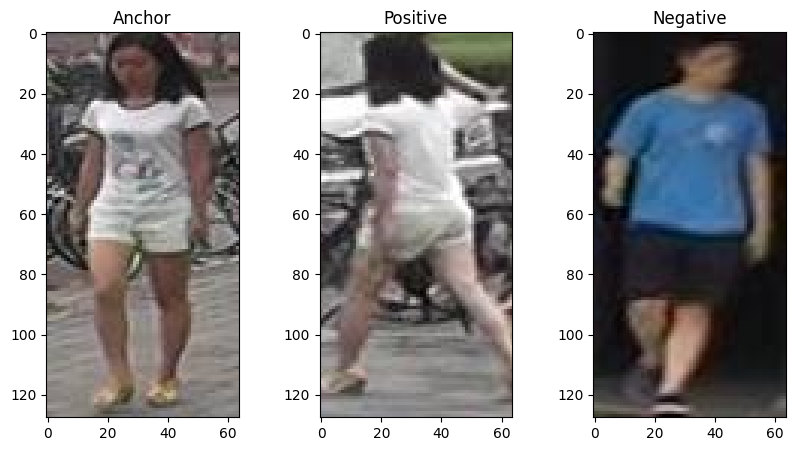

In [46]:
f, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(10,5))
ax1.set_title('Anchor')
ax1.imshow(A_img)

ax2.set_title('Positive')
ax2.imshow(P_img)

ax3.set_title('Negative')
ax3.imshow(N_img)

In [47]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 42)

# Create APN Dataset

In [48]:
class APN_Dataset(Dataset):
  def __init__(self,df):
    self.df = df

  def __len__(self):
    return len(self.df)

  def __getitem__(self,idx):
    row = self.df.iloc[idx]
    A_img = io.imread(DATA_DIR + row.Anchor)
    P_img = io.imread(DATA_DIR + row.Positive)
    N_img = io.imread(DATA_DIR + row.Negative)

    A_img = torch.from_numpy(A_img).permute(2,0,1)/255.0
    P_img = torch.from_numpy(P_img).permute(2,0,1)/255.0
    N_img = torch.from_numpy(N_img).permute(2,0,1)/255.0

    return A_img, P_img, N_img



In [49]:
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)

print(f"Size of trainset : {len(trainset)}")
print(f"Size of validset : {len(validset)}")


Size of trainset : 3200
Size of validset : 800


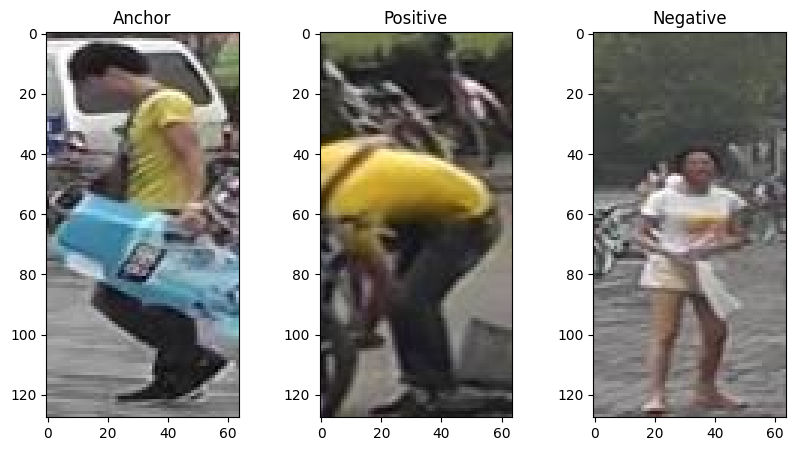

In [50]:
idx = 40
A,P,N = trainset[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

# Load Dataset into Batches

In [51]:
trainloader = DataLoader(trainset,batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset,batch_size = BATCH_SIZE)

In [52]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 100
No. of batches in validloader : 25


In [53]:
for A,P,N in trainloader:
  break;

print(f"One image batch shape : {A.shape}")

One image batch shape : torch.Size([32, 3, 128, 64])


# Create Model

In [54]:
class APN_model(nn.Module):
  def __init__(self, emb_size=512):
    super(APN_model,self).__init__()

    self.efficientnet = timm.create_model('efficientnet_b0',pretrained = True)
    self.efficientnet.classifier = nn.Linear(in_features =self.efficientnet.classifier.in_features, out_features = emb_size )

  def forward(self,images):
    embeddings = self.efficientnet(images)
    return embeddings

In [55]:
model = APN_model()
model.to(DEVICE)

APN_model(
  (efficientnet): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size

# Create Train and Eval function

In [56]:
def train_fn(model, dataloader, optimizer, criterion):

  model.train()
  total_loss = 0.0
  for A,P,N in tqdm(dataloader):

    A,P,N, = A.to(DEVICE) ,P.to(DEVICE) ,N.to(DEVICE)

    A_embs = model(A)
    P_embs = model(P)
    N_embs = model(N)

    loss = criterion(A_embs,P_embs,N_embs)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss+=loss.item()

  return total_loss/len(dataloader)

In [57]:
def eval_fn(model, dataloader, criterion):

  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for A,P,N in tqdm(dataloader):

      A,P,N, = A.to(DEVICE) ,P.to(DEVICE) ,N.to(DEVICE)

      A_embs = model(A)
      P_embs = model(P)
      N_embs = model(N)

      loss = criterion(A_embs,P_embs,N_embs)

      total_loss+=loss.item()

    return total_loss/len(dataloader)

In [58]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

# Create Training Loop

In [59]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(model,trainloader,optimizer, criterion)
  valid_loss = eval_fn(model,validloader,criterion)

  if valid_loss<best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    best_valid_loss = valid_loss
    print('Saved_weights_successfully')

  print(f"EPOCHS:{i+1} | train_loss : {train_loss} | valid_loss = {valid_loss}")

100%|██████████| 25/25 [00:02<00:00, 10.15it/s]


Saved_weights_successfully
EPOCHS:1 | train_loss : 0.5987402015924453 | valid_loss = 0.5868859994411468


100%|██████████| 25/25 [00:02<00:00, 10.12it/s]


Saved_weights_successfully
EPOCHS:2 | train_loss : 0.30879915893077853 | valid_loss = 0.32730059683322904


100%|██████████| 25/25 [00:02<00:00,  9.42it/s]


Saved_weights_successfully
EPOCHS:3 | train_loss : 0.18433886557817458 | valid_loss = 0.32692757904529574


100%|██████████| 25/25 [00:02<00:00,  9.67it/s]


Saved_weights_successfully
EPOCHS:4 | train_loss : 0.15128636181354524 | valid_loss = 0.24337076127529145


100%|██████████| 25/25 [00:02<00:00, 10.63it/s]


Saved_weights_successfully
EPOCHS:5 | train_loss : 0.09010285288095474 | valid_loss = 0.22672454833984376


100%|██████████| 25/25 [00:02<00:00, 10.67it/s]


EPOCHS:6 | train_loss : 0.06203602991998196 | valid_loss = 0.22860472321510314


100%|██████████| 25/25 [00:02<00:00,  8.89it/s]


Saved_weights_successfully
EPOCHS:7 | train_loss : 0.057246806547045705 | valid_loss = 0.18243468701839446


100%|██████████| 25/25 [00:02<00:00, 10.60it/s]


EPOCHS:8 | train_loss : 0.048518323749303816 | valid_loss = 0.24304870069026946


100%|██████████| 25/25 [00:03<00:00,  8.27it/s]


Saved_weights_successfully
EPOCHS:9 | train_loss : 0.054421609193086626 | valid_loss = 0.11667069733142853


100%|██████████| 25/25 [00:04<00:00,  5.84it/s]


EPOCHS:10 | train_loss : 0.034587738811969755 | valid_loss = 0.13668936640024185


100%|██████████| 25/25 [00:02<00:00,  8.41it/s]


EPOCHS:11 | train_loss : 0.05089846640825271 | valid_loss = 0.23215607881546022


100%|██████████| 25/25 [00:02<00:00,  9.19it/s]


EPOCHS:12 | train_loss : 0.04688971534371376 | valid_loss = 0.19219847828149794


100%|██████████| 25/25 [00:03<00:00,  8.28it/s]


EPOCHS:13 | train_loss : 0.02906245246529579 | valid_loss = 0.14527399331331253


100%|██████████| 25/25 [00:03<00:00,  7.92it/s]


EPOCHS:14 | train_loss : 0.030198320001363754 | valid_loss = 0.19436168551445007


100%|██████████| 25/25 [00:04<00:00,  5.73it/s]


EPOCHS:15 | train_loss : 0.028972349911928177 | valid_loss = 0.1868835312128067


100%|██████████| 25/25 [00:03<00:00,  7.01it/s]


EPOCHS:16 | train_loss : 0.03741027273237705 | valid_loss = 0.16566550016403198


100%|██████████| 25/25 [00:02<00:00,  9.37it/s]


EPOCHS:17 | train_loss : 0.057650438025593755 | valid_loss = 0.21450477480888366


100%|██████████| 25/25 [00:02<00:00,  8.86it/s]


EPOCHS:18 | train_loss : 0.05498859986662865 | valid_loss = 0.2576460832357407


100%|██████████| 25/25 [00:02<00:00, 10.37it/s]


EPOCHS:19 | train_loss : 0.06596306622028351 | valid_loss = 0.16698087573051454


100%|██████████| 25/25 [00:04<00:00,  5.92it/s]


EPOCHS:20 | train_loss : 0.04247586198151112 | valid_loss = 0.1783094424009323


100%|██████████| 25/25 [00:02<00:00,  8.69it/s]


EPOCHS:21 | train_loss : 0.02768342286348343 | valid_loss = 0.21565779745578767


100%|██████████| 25/25 [00:02<00:00, 10.42it/s]


Saved_weights_successfully
EPOCHS:22 | train_loss : 0.041905434355139735 | valid_loss = 0.10129380822181702


100%|██████████| 25/25 [00:03<00:00,  8.29it/s]


EPOCHS:23 | train_loss : 0.020517115965485572 | valid_loss = 0.1491748136281967


100%|██████████| 25/25 [00:02<00:00, 10.14it/s]


EPOCHS:24 | train_loss : 0.012617741078138352 | valid_loss = 0.16111265629529953


100%|██████████| 25/25 [00:02<00:00, 10.25it/s]

EPOCHS:25 | train_loss : 0.016478790938854217 | valid_loss = 0.13885828852653503


# Get Anchor Embeddings

In [61]:
def get_encoding_csv(model, anc_img_names):
  anc_img_names_arr = np.array(anc_img_names)
  encodings = []

  model.eval()
  with torch.no_grad():
    for i in tqdm(anc_img_names_arr):
      A = io.imread(DATA_DIR + i)
      A = torch.from_numpy(A).permute(2,0,1)/255.0
      A = A.to(DEVICE)
      A_enc = model(A.unsqueeze(0))
      encodings.append(A_enc.squeeze().cpu().detach().numpy())

    encodings = np.array(encodings)
    encodings = pd.DataFrame(encodings)
    df_enc = pd.concat([anc_img_names, encodings], axis = 1)

  return df_enc

In [62]:
model.load_state_dict(torch.load('best_model.pt'))
df_enc = get_encoding_csv(model, df['Anchor'])

100%|██████████| 4000/4000 [01:01<00:00, 65.20it/s]


In [63]:
df_enc.to_csv('database.csv',index=False)
df_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,1420_c5s3_052165_01.jpg,-0.200766,-0.330177,0.170213,-0.431126,-0.921063,0.684746,0.406173,1.040044,-1.815487,...,-0.016408,0.768696,0.588550,-0.847279,-0.167483,-0.259300,0.707361,-0.036952,0.387772,-0.729550
1,1420_c3s3_061978_03.jpg,-0.362137,-0.076014,-0.135367,-0.396051,-1.259926,0.173133,0.532627,1.002977,-1.972675,...,0.134043,0.588522,0.804463,-0.837766,-0.074388,-0.081380,1.002385,-0.330306,0.692172,-0.775425
2,1420_c5s3_062565_05.jpg,-0.176493,-0.283351,0.043601,-0.308066,-0.964680,0.517618,0.373360,0.738905,-1.965020,...,-0.029363,0.882035,0.541208,-1.011118,-0.030802,-0.188521,0.776503,0.119483,0.432662,-0.792140
3,1420_c6s3_085592_04.jpg,-0.080929,-0.296341,0.279203,-0.501420,-1.360086,0.548042,0.225015,0.607924,-2.284401,...,-0.435825,1.075275,0.439339,-1.381006,-0.006137,0.134728,0.991206,0.014423,0.320566,-0.747785
4,0663_c5s3_085987_03.jpg,-0.190573,-0.474485,0.555826,-0.418063,-0.211771,0.101453,-0.824322,-0.733285,0.363343,...,-1.262806,0.638413,-0.290778,-1.458793,-0.529446,0.575148,0.224854,0.347638,-0.702330,-0.084328


# Inference

In [64]:
def euclidean_dist(img_enc, anc_enc_arr):
  dist = np.sqrt(np.dot(img_enc-anc_enc_arr,(img_enc-anc_enc_arr ).T))
  return dist


In [66]:
idx = 0
img_name = df_enc['Anchor'].iloc[idx]
img_path = DATA_DIR + img_name

img = io.imread(img_path)
img = torch.from_numpy(img).permute(2,0,1) / 255.0

model.eval()
with torch.no_grad():
  img = img.to(DEVICE)
  img_enc = model(img.unsqueeze(0))
  img_enc = img_enc.detach().cpu().numpy()

In [69]:
anc_enc_arr = df_enc.iloc[:,1:].to_numpy()
anc_img_names = df_enc['Anchor']

In [70]:
distance = []
for i in range(anc_enc_arr.shape[0]):
  dist = euclidean_dist(img_enc,anc_enc_arr[i:i+1, :])
  distance = np.append(distance,dist)

In [71]:
closest_idx = np.argsort(distance)

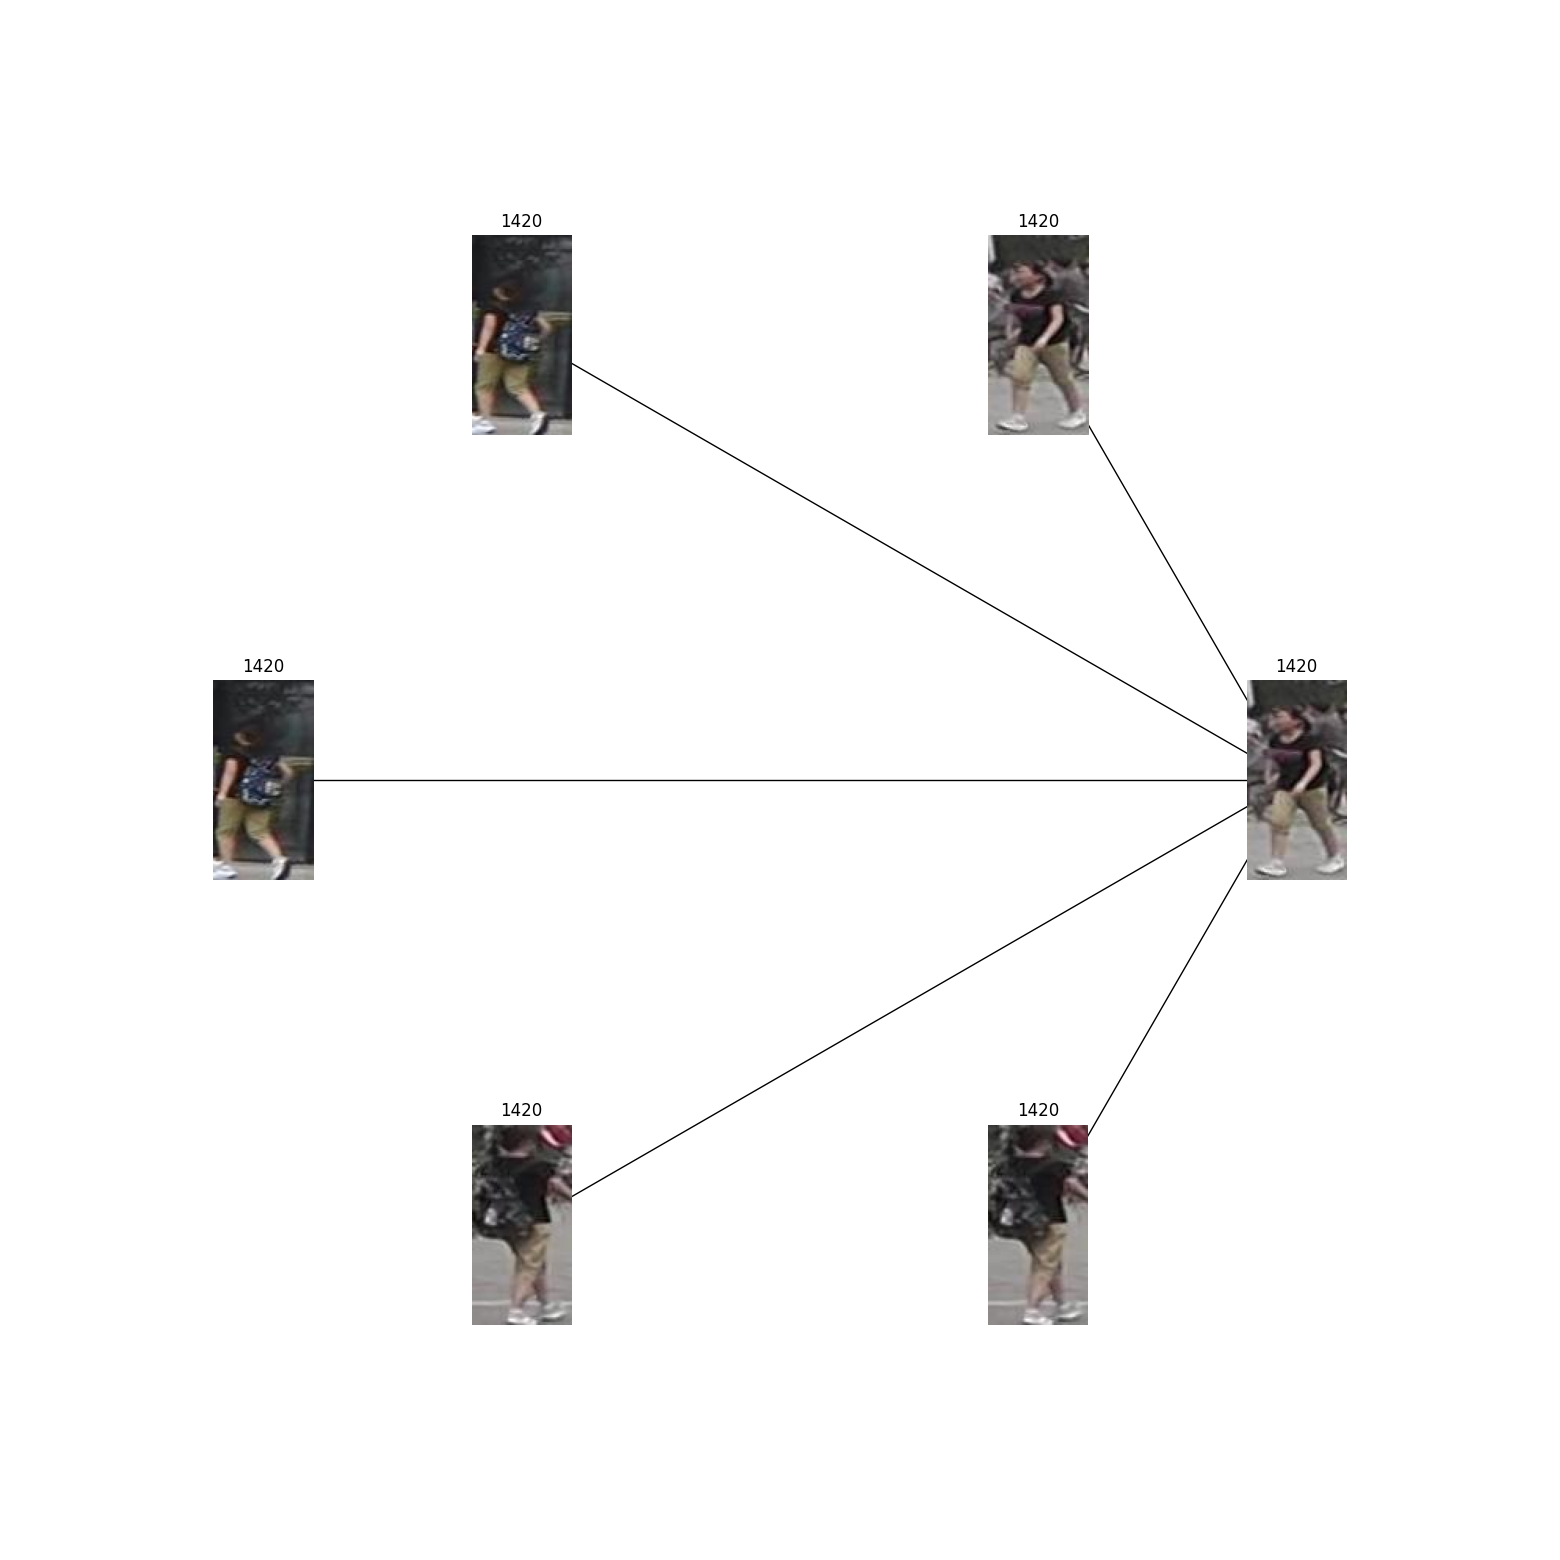

In [74]:
from utils import plot_closest_imgs

plot_closest_imgs(anc_img_names, DATA_DIR, img, img_path, closest_idx, distance, no_of_closest = 5);